In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [7]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

def make_plots():
    metric = df.columns[0]
    
    for subset in subsets:
        n_pos, n_neg = sample_size[subset]
        if metric == "AUROC":
            baseline = 0.5
        elif metric == "AUPRC":
            baseline = n_pos / (n_pos + n_neg)
        elif metric == "Odds ratio":
            baseline = 1
        g = sns.catplot(
            data=df[df.subset==subset],
            y="feature",
            x=metric,
            row="Model",
            sharex=True,
            sharey=False,
            kind="bar",
            color="C0",
            height=2,
            aspect=2,
        )
        g.set(
            xlim=baseline,
            ylabel="",
        )
        g.set_titles("{row_name}")
        sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        plt.suptitle(
            f"{subset_renaming.get(subset, subset)}\n{sample_size_str}",
            x=1.0,
            y=1.05,
        )
        #plt.savefig("top_features.pdf", bbox_inches="tight")
        plt.show()

In [8]:
subset_renaming = {
    "174500": "Polydactyly (enhancer)",
    "306900": "Hemophilia B (promoter)",
    "600886": "Hyperferritinemia (5' UTR)",
}

In [32]:
enformer_renaming = pd.read_csv("../../results/metadata/Enformer.csv")
for col in ["name", "description"]:
    enformer_renaming[col] = "Enformer_L2_" + enformer_renaming[col]
enformer_renaming = enformer_renaming.set_index("name").description.str[:30].to_dict()

borzoi_renaming = pd.read_csv("../../results/metadata/Borzoi.csv")
for col in ["name", "description"]:
    borzoi_renaming[col] = "Borzoi_L2_" + borzoi_renaming[col]
borzoi_renaming = borzoi_renaming.set_index("name").description.str[:30].to_dict()

feature_renaming = {**enformer_renaming, **borzoi_renaming}
feature_renaming

{'Enformer_L2_ENCFF833POA': 'Enformer_L2_DNASE:cerebellum m',
 'Enformer_L2_ENCFF110QGM': 'Enformer_L2_DNASE:frontal cort',
 'Enformer_L2_ENCFF880MKD': 'Enformer_L2_DNASE:chorion',
 'Enformer_L2_ENCFF463ZLQ': 'Enformer_L2_DNASE:Ishikawa tre',
 'Enformer_L2_ENCFF890OGQ': 'Enformer_L2_DNASE:GM03348',
 'Enformer_L2_ENCFF996AEF': 'Enformer_L2_DNASE:GM03348 gene',
 'Enformer_L2_ENCFF660YSU': 'Enformer_L2_DNASE:AG08395',
 'Enformer_L2_ENCFF787MSC': 'Enformer_L2_DNASE:AG08396',
 'Enformer_L2_ENCFF568LMQ': 'Enformer_L2_DNASE:AG20443',
 'Enformer_L2_ENCFF685MZL': 'Enformer_L2_DNASE:frontal cort',
 'Enformer_L2_ENCFF452DLO': 'Enformer_L2_DNASE:H54',
 'Enformer_L2_ENCFF149TAY': 'Enformer_L2_DNASE:GM10248',
 'Enformer_L2_ENCFF093VXI': 'Enformer_L2_DNASE:GM12878',
 'Enformer_L2_ENCFF713YTW': 'Enformer_L2_DNASE:GM12891',
 'Enformer_L2_ENCFF536IEC': 'Enformer_L2_DNASE:GM12892',
 'Enformer_L2_ENCFF714ZSE': 'Enformer_L2_DNASE:GM18507',
 'Enformer_L2_ENCFF385ITM': 'Enformer_L2_DNASE:GM19238',
 'Enformer

In [26]:
#dataset = "omim_subsampled_9"
#subsets = [
#    "all",
#    "174500",
#    "306900",
#    "600886",
#]

dataset = "gwas_matched_9"
subsets = [
    "all",
    "Height",
    "MCV",
    "Mono",
    "eBMD",
]

#dataset = "eqtl_matched_1"
#subsets = [
#    "all",
#    "Whole_Blood",
#    "Lung",
#    "Brain_Cortex",
#    "Liver",
#]

base_dir = f"../../results/dataset/{dataset}"
V = pd.read_parquet(f"{base_dir}/test.parquet")

## Marginal performance

In [17]:
LLR_version = "LLR"
#LLR_version = "absLLR"

models = pd.DataFrame(
    [
        ["Enformer", "Enformer_L2", "C0"],
        ["Borzoi", "Borzoi_L2", "C1"],
        ["CADD", "CADD", "C2"],
    ],
    columns=["Model", "path", "color"]
).set_index("Model")
models

,path,color
Model,,
Enformer,Enformer_L2,C0
Borzoi,Borzoi_L2,C1
CADD,CADD,C2


In [26]:
dfs = []
sample_size = {}

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    for model in models.index:
        df = pd.read_csv(f"{base_dir}/unsupervised_metrics/{subset}/{models.loc[model, 'path']}.csv")
        if model == "Enformer":
            df.feature = df.feature.map(enformer_renaming)
            df = df.drop_duplicates("feature")
        elif model == "Borzoi":
            df.feature = df.feature.map(borzoi_renaming)
            df = df.drop_duplicates("feature")
        df = df.head(5)
        df["subset"] = subset
        df["Model"] = model
        dfs.append(df)
df = pd.concat(dfs)
df

100%|█████████████| 4/4 [00:00<00:00, 22.10it/s]


,AUPRC,feature,subset,Model
0,0.567093,"CAGE:liver, fetal, pool1",all,Enformer
1,0.487440,CAGE:gastrointestinal carcinom,all,Enformer
2,0.486382,CAGE:SABiosciences XpressRef H,all,Enformer
3,0.484851,CAGE:Universal RNA - Human Nor,all,Enformer
4,0.478590,"CAGE:Hepatocyte,",all,Enformer
0,0.584785,"CAGE:liver, fetal, pool1",all,Borzoi
2,0.549161,RNA:liver tissue female embryo,all,Borzoi
3,0.544058,RNA:right lobe of liver tissue,all,Borzoi
5,0.540158,"CAGE:Hepatocyte,",all,Borzoi
7,0.537682,RNA:left lobe of liver tissue,all,Borzoi


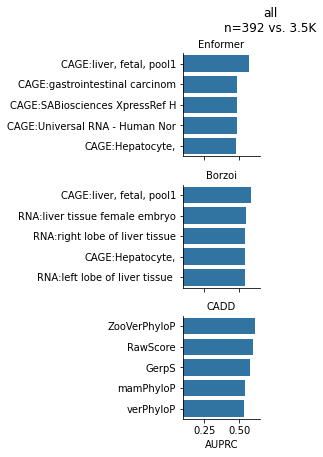

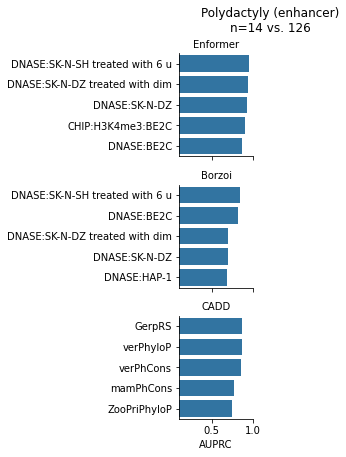

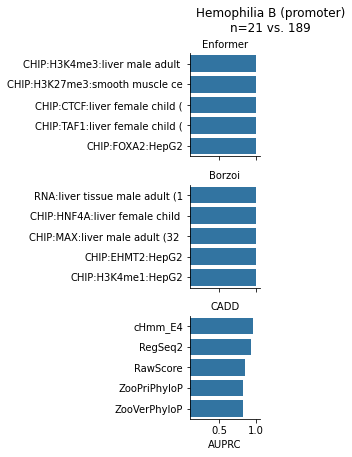

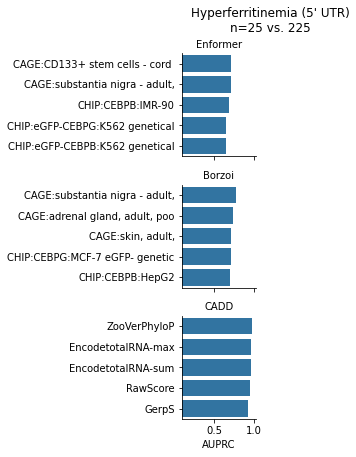

In [28]:
# OMIM
make_plots()

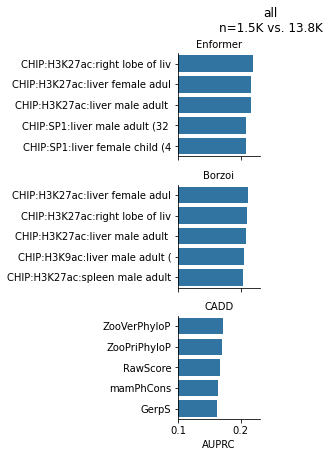

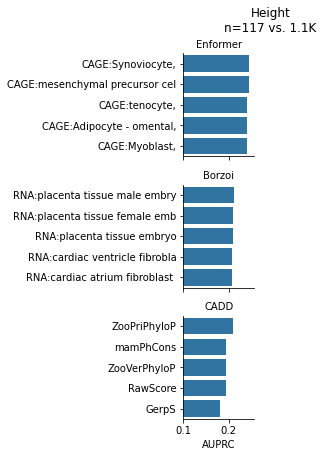

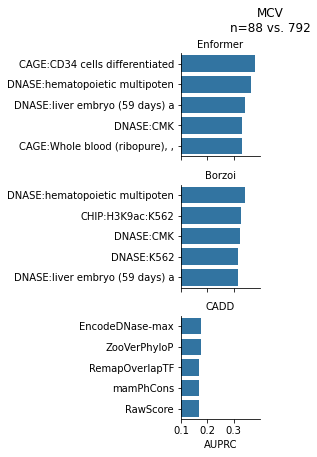

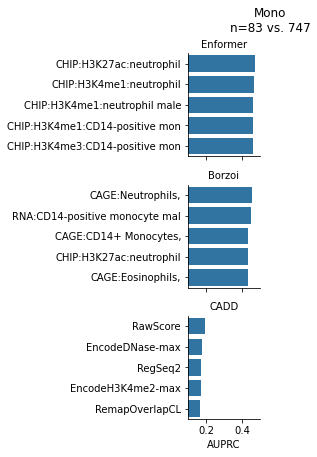

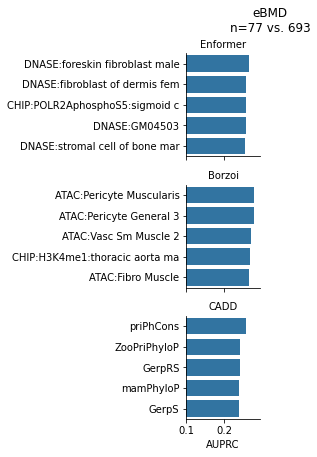

In [14]:
# GWAS
make_plots()

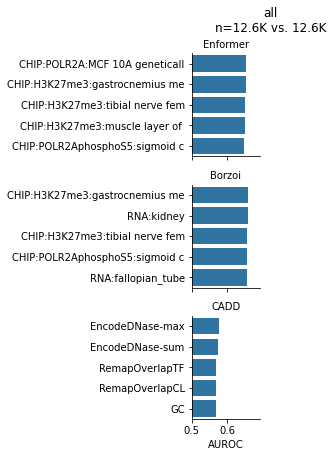

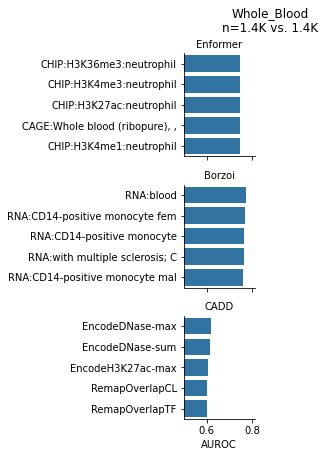

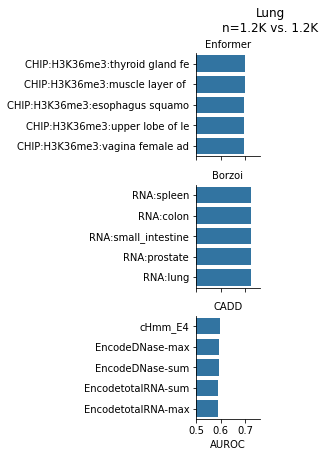

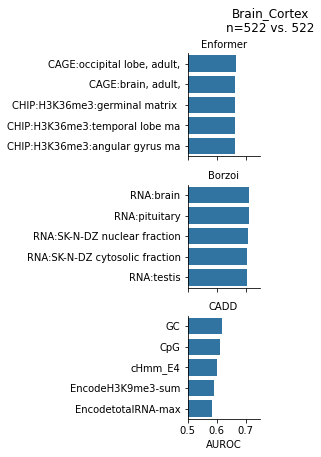

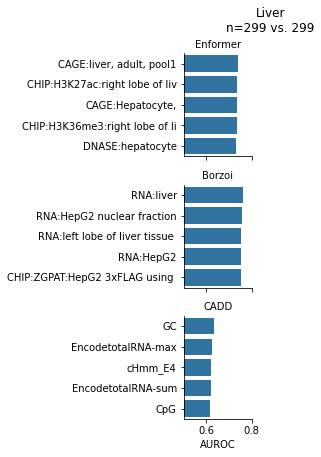

In [16]:
# eQTL
make_plots()

In [24]:
V2.OMIM.value_counts().head(20)

OMIM
MIM 600886    25
MIM 613985    24
MIM 614743    22
MIM 250250    21
MIM 306900    21
MIM 174500    14
MIM 143890    12
MIM 210710    10
MIM 188000     9
MIM 141749     6
MIM 306700     6
MIM 180200     6
MIM 616651     5
MIM 302800     5
MIM 146550     5
MIM 227500     5
MIM 615935     5
MIM 609637     4
MIM 608030     4
MIM 600496     4
Name: count, dtype: int64

## Coefficients

In [28]:
enformer_renaming

{'ENCFF833POA': 'DNASE:cerebellum male adult (2',
 'ENCFF110QGM': 'DNASE:frontal cortex male adul',
 'ENCFF880MKD': 'DNASE:chorion',
 'ENCFF463ZLQ': 'DNASE:Ishikawa treated with 0.',
 'ENCFF890OGQ': 'DNASE:GM03348',
 'ENCFF996AEF': 'DNASE:GM03348 genetically modi',
 'ENCFF660YSU': 'DNASE:AG08395',
 'ENCFF787MSC': 'DNASE:AG08396',
 'ENCFF568LMQ': 'DNASE:AG20443',
 'ENCFF685MZL': 'DNASE:frontal cortex female ad',
 'ENCFF452DLO': 'DNASE:H54',
 'ENCFF149TAY': 'DNASE:GM10248',
 'ENCFF093VXI': 'DNASE:GM12878',
 'ENCFF713YTW': 'DNASE:GM12891',
 'ENCFF536IEC': 'DNASE:GM12892',
 'ENCFF714ZSE': 'DNASE:GM18507',
 'ENCFF385ITM': 'DNASE:GM19238',
 'ENCFF919WIT': 'DNASE:GM19239',
 'ENCFF814MPK': 'DNASE:GM19240',
 'ENCFF153XQL': 'DNASE:H1-hESC',
 'ENCFF753SCX': 'DNASE:H7-hESC',
 'ENCFF663TLI': 'DNASE:H9',
 'ENCFF082SFS': 'DNASE:heart male adult (27 yea',
 'ENCFF148BGE': 'DNASE:HEK293T',
 'ENCFF422TAV': 'DNASE:HeLa-S3 treated with int',
 'ENCFF050BDU': 'DNASE:HeLa-S3',
 'ENCFF818FXA': 'DNASE:hepatocyt

In [33]:
dfs = []
sample_size = {}
#model = "OMIM_Ensemble"
model = "Enformer+GPN-MSA+CADD"

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    df = pd.read_csv(f"{base_dir}/coefficients/{subset}/{model}.csv")
    df.feature = df.feature.apply(lambda x: feature_renaming.get(x, x))
    df = df.head(10)
    df["subset"] = subset
    dfs.append(df)
df = pd.concat(dfs)
df

100%|████████████████████████████████████████| 5/5 [00:00<00:00, 28.31it/s]


,feature,coef,subset
0,CADD_Freq10000bp,-0.043467,all
1,CADD_ZooVerPhyloP,0.036523,all
2,CADD_RawScore,0.035219,all
3,CADD_Freq1000bp,-0.032111,all
4,GPN-MSA_absLLR_score,0.025932,all
5,CADD_mamPhCons,0.025813,all
6,CADD_ZooPriPhyloP,0.025361,all
7,CADD_SIFTval,-0.022129,all
8,"Enformer_L2_CAGE:Hepatocyte,",0.021947,all
9,CADD_verPhCons,0.021780,all


In [24]:
def plot_coef():
    for subset in subsets:
        n_pos, n_neg = sample_size[subset]
        plt.figure(figsize=(3, 3))
        g = sns.barplot(
            data=df[df.subset==subset],
            y="feature",
            x="coef",
            color="C0",
        )
        g.set(
            ylabel="",
        )
        sns.despine()
        sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        plt.title(
            f"{subset_renaming.get(subset, subset)}\n{sample_size_str}",
        )
        plt.show()

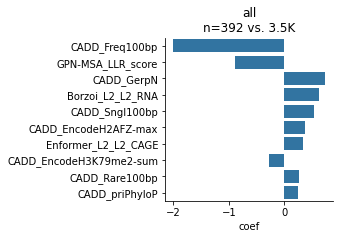

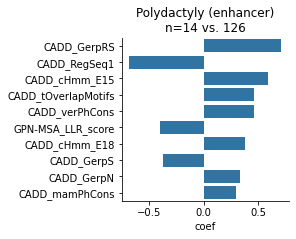

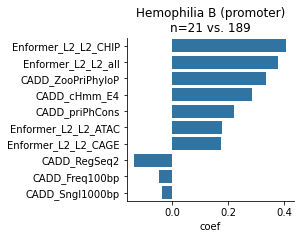

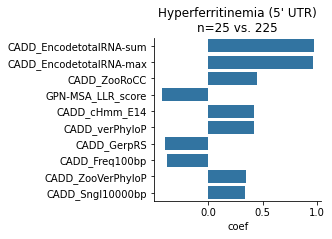

In [25]:
# OMIM
plot_coef()

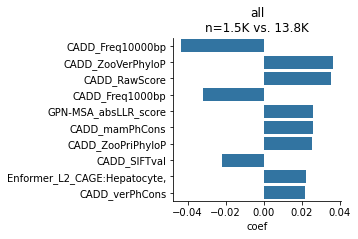

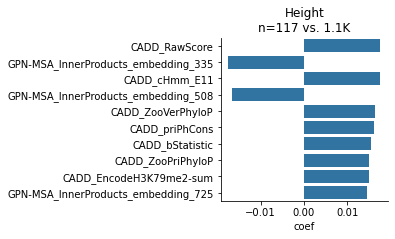

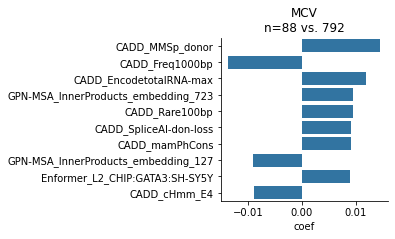

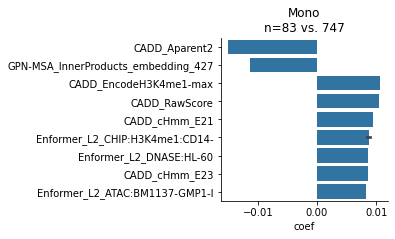

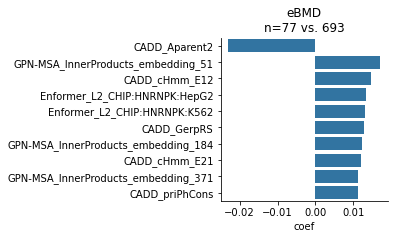

In [34]:
# GWAS
plot_coef()